## Table of Contents

### Chapter 1: High-Level API (OdeSystem & LowLevelODE)
1. [Introduction](#1.1.-Introduction)
2. [Basic ODE Systems](#1.2.-Basic-ODE-Systems)
3. [Symbolic vs Python Functions](#1.3.-Symbolic-vs-Python-Functions)
4. [Integration Methods](#1.4.-Integration-Methods)
5. [Event Detection](#1.5.-Event-Detection)
6. [Advanced Integration](#1.6.-Advanced-Integration)
7. [Variational Equations & Lyapunov Exponents](#1.7.-Variational-Equations-&-Lyapunov-Exponents)
8. [Hamiltonian Systems](#1.8.-Hamiltonian-Systems)
9. [Parallel Integration](#1.9.-Parallel-Integration)
10. [Numerical Precision](#1.10.-Numerical-Precision)
11. [Performance Tips](#1.11.-Performance-Tips)

### Chapter 2: Low-Level API (OdeSolver Classes)
1. [Introduction to OdeSolver](#2.1.-Introduction-to-OdeSolver)
2. [Basic OdeSolver Usage](#2.2.-Basic-OdeSolver-Usage)
3. [Custom Termination Conditions](#2.3.-Custom-Termination-Conditions)
4. [Real-Time Monitoring](#2.4.-Real-Time-Monitoring)
5. [Solver State Inspection](#2.5.-Solver-State-Inspection)
6. [Copying and Resetting](#2.6.-Copying-and-Resetting)
7. [Event Detection with OdeSolver](#2.7.-Event-Detection-with-OdeSolver)
8. [OdeSolver Reference](#2.8.-OdeSolver-Reference)

# Chapter 1: High-Level API

The high-level API provides `OdeSystem` for symbolic ODE definition and `LowLevelODE` for convenient integration with automatic history accumulation. This is the recommended API for most users.

Key features:
- Symbolic compilation to C++ for 50-200x speedup
- Automatic history accumulation
- Simple interface: define once, integrate anywhere
- Built-in support for events, variational equations, and Hamiltonian systems

## 1.1. Introduction

ODEPACK is a modern C++ header library for solving ordinary differential equations (ODEs). The Python extension provides:

- **High Performance**: 100-500x faster than pure Python implementations
- **Symbolic Compilation**: Automatically compile symbolic expressions to C++
- **Event Detection**: Precisely detect and handle events during integration
- **Multiple Methods**: RK23, RK45, DOP853, and BDF for stiff problems
- **Variational Equations**: Built-in support for Lyapunov exponent computation
- **Arbitrary Precision**: Support for double, float, long double, and mpreal (arbitrary precision) types

Internally, the compiled solvers perform no memory allocations/deallocations during integrating, besides their initialization, and the accumulated integrated history.

Let's start by importing the package:

In [1]:
from odepack import *
import numpy as np
import matplotlib.pyplot as plt

# Set up plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1.2. Basic ODE Systems

### 1.2.1 Defining an ODE System

An ODE system has the form:

$$\frac{dq}{dt} = F(t, q, \text{args})$$

where:
- $t$ is time
- $q$ is the state vector
- $\text{args}$ are optional parameters

Let's solve a simple harmonic oscillator: $\ddot{x} + x = 0$

We convert it to a first-order system:
$$\frac{d}{dt}\begin{bmatrix}x \\ v\end{bmatrix} = \begin{bmatrix}v \\ -x\end{bmatrix}$$

Compiling...
Done


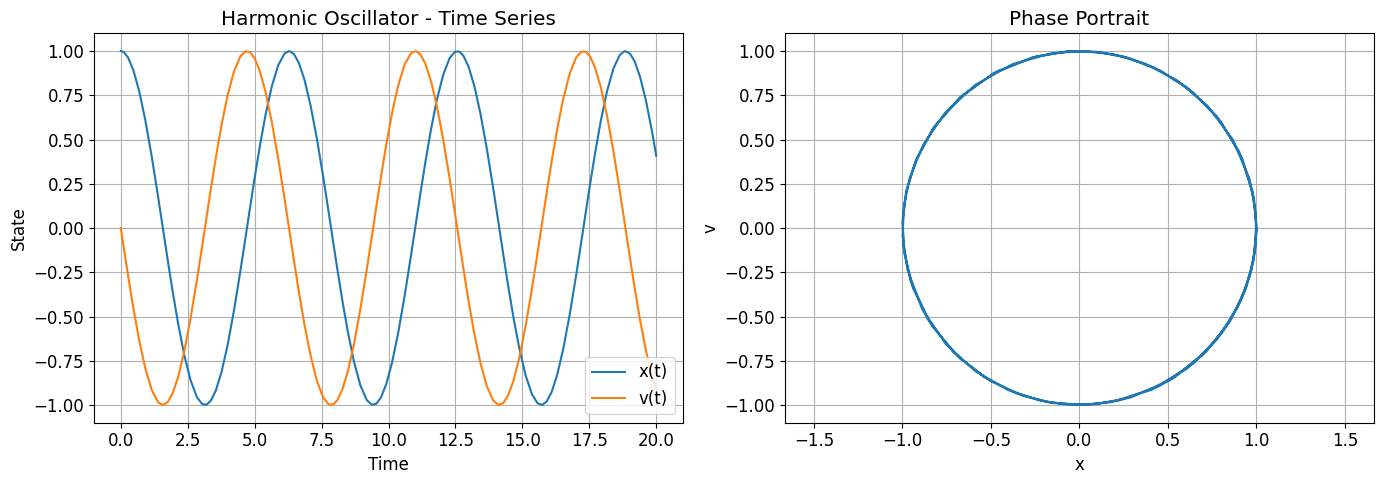

Integration completed in 0.000034 seconds
Number of steps: 104
Success: True


In [2]:
# Define symbolic variables
t, x, v = symbols('t, x, v')

# Create the ODE system
system = OdeSystem(
    ode_sys=[v, -x],  # dx/dt = v, dv/dt = -x
    t=t,
    q=[x, v],
    args=()  # No parameters
)

# Create a solver
solver = system.get(
    t0=0.0,           # Initial time
    q0=[1.0, 0.0],    # Initial conditions: x=1, v=0
    method="RK45",    # Integration method
    rtol=1e-6,        # Relative tolerance
    atol=1e-12        # Absolute tolerance
)

# Integrate from t=0 to t=20
result = solver.integrate(20.0)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(result.t, result.q[:, 0], label='x(t)')
ax1.plot(result.t, result.q[:, 1], label='v(t)')
ax1.set_xlabel('Time')
ax1.set_ylabel('State')
ax1.set_title('Harmonic Oscillator - Time Series')
ax1.legend()
ax1.grid(True)

ax2.plot(result.q[:, 0], result.q[:, 1])
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_title('Phase Portrait')
ax2.grid(True)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"Integration completed in {result.runtime:.6f} seconds")
print(f"Number of steps: {len(result.t)}")
print(f"Success: {result.success}")

### 1.2.2 Systems with Parameters

Let's solve the Lotka-Volterra predator-prey model:

$$\frac{dx}{dt} = ax - bxy$$
$$\frac{dy}{dt} = cxy - dy$$

where $a, b, c, d$ are parameters.

Compiling...
Done


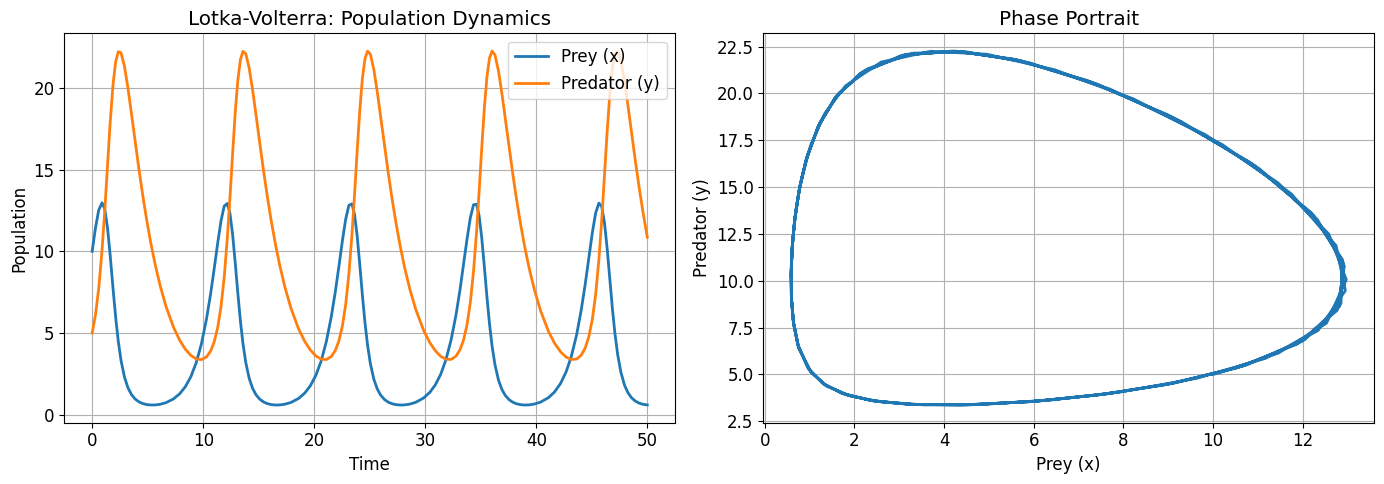

In [3]:
# Define symbolic variables
t, x, y, a, b, c, d = symbols('t, x, y, a, b, c, d')

# Create the system
lotka_volterra = OdeSystem(
    ode_sys=[a*x - b*x*y, c*x*y - d*y],
    t=t,
    q=[x, y],
    args=[a, b, c, d]  # Parameters
)

# Create solver with specific parameter values
solver = lotka_volterra.get(
    t0=0.0,
    q0=[10.0, 5.0],          # Initial populations
    args=(1.0, 0.1, 0.1, 0.4),  # Parameter values
    method="RK45"
)

# Integrate
result = solver.integrate(50.0)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(result.t, result.q[:, 0], label='Prey (x)', linewidth=2)
ax1.plot(result.t, result.q[:, 1], label='Predator (y)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax1.set_title('Lotka-Volterra: Population Dynamics')
ax1.legend()
ax1.grid(True)

ax2.plot(result.q[:, 0], result.q[:, 1], linewidth=2)
ax2.set_xlabel('Prey (x)')
ax2.set_ylabel('Predator (y)')
ax2.set_title('Phase Portrait')
ax2.grid(True)

plt.tight_layout()
plt.show()

## 1.3. Symbolic vs Python Functions

ODEPACK supports two ways to define ODEs:
1. **Symbolic** (recommended): Automatically translates functions to C++ and compiles them for maximum performance
2. **Python functions**: Nothing to compile, but slower

Let's compare the performance using the Van der Pol oscillator:

$$\ddot{x} = \mu(1-x^2)\dot{x} - x$$

In [4]:
# === SYMBOLIC APPROACH ===
t, x, y, mu = symbols('t, x, y, mu')

system_symbolic = OdeSystem(
    ode_sys=[y, mu*(1 - x**2)*y - x],
    t=t,
    q=[x, y],
    args=[mu]
)

# Compiled solver
solver_compiled = system_symbolic.get(
    t0=0, q0=[1.0, 2.0],
    args=(500,),
    method="BDF",  # BDF for stiff problems
    rtol=1e-13, atol=1e-13
)

# === PYTHON FUNCTION APPROACH ===
def van_der_pol(t, q, mu):
    x, y = q
    return np.array([y, mu*(1 - x**2)*y - x])

def van_der_pol_jac(t, q, mu):
    x, y = q
    return np.array([[0, 1], [-2*mu*x*y - 1, mu*(1-x**2)]])

solver_python = LowLevelODE(
    van_der_pol,
    jac=van_der_pol_jac,
    t0=0, q0=[1.0, 2.0],
    args=(500,),
    method="BDF",
    rtol=1e-13, atol=1e-13
)

# Compare performance
print("Integrating from t=0 to t=400...\n")

result_compiled = solver_compiled.integrate(400)
print(f"Compiled (symbolic):  {result_compiled.runtime:.6f} seconds, {len(result_compiled.t)} steps")

result_python = solver_python.integrate(400)
print(f"Python functions:     {result_python.runtime:.6f} seconds, {len(result_python.t)} steps")

speedup = result_python.runtime / result_compiled.runtime
print(f"\nSpeedup: {speedup:.1f}x faster with compiled code!")

Compiling...
Done
Integrating from t=0 to t=400...

Compiled (symbolic):  0.001724 seconds, 6135 steps
Python functions:     0.026980 seconds, 6170 steps

Speedup: 15.7x faster with compiled code!


### 1.3.1 Extracting Compiled Functions

You can also extract the compiled functions directly:

In [5]:
# Get compiled right-hand side function
rhs_compiled = system_symbolic.lowlevel_odefunc('double')
jac_compiled = system_symbolic.lowlevel_jac('double')

# Test the compiled function
q_test = np.array([1.0, 2.0])
result_rhs = rhs_compiled(0.0, q_test, 500.0)
print(f"Right-hand side at q={q_test}: {result_rhs}")

# You can also get event objects
events_compiled = system_symbolic.true_compiled_events() #prints empty list in this case, as no events were defined (introduced later)
print(f"\nCompiled events: {events_compiled}")

Compiling...
Done
Right-hand side at q=[1. 2.]: [ 2. -1.]

Compiled events: []


## 1.4. Integration Methods

ODEPACK provides four integration methods:

| Method | Order | Type | Best For |
|--------|-------|------|----------|
| **RK23** | 2(3) | Explicit | Low accuracy, fast |
| **RK45** | 4(5) | Explicit | General purpose (default) |
| **DOP853** | 8(5,3) | Explicit | High accuracy |
| **BDF** | Variable | Implicit | Stiff problems |

### 1.4.1 Comparing Methods on a Non-Stiff Problem

In [6]:
# Simple oscillator
t, x, v = symbols('t, x, v')
system = OdeSystem([v, -x], t, [x, v])

methods = ['RK23', 'RK45', 'DOP853']
results = {}

for method in methods:
    solver = system.get(t0=0, q0=[1.0, 0.0], method=method)
    results[method] = solver.integrate(100.0)
    
print("Method Comparison (t=0 to t=100):")
print(f"{'Method':<10} {'Runtime (s)':<15} {'Steps':<10} {'Final Error'}")
print("-" * 55)

for method in methods:
    r = results[method]
    # Analytical solution: x(t) = cos(t), v(t) = -sin(t)
    x_true = np.cos(r.t[-1])
    error = abs(r.q[-1, 0] - x_true)
    print(f"{method:<10} {r.runtime:<15.6f} {len(r.t):<10} {error:.3e}")

Method Comparison (t=0 to t=100):
Method     Runtime (s)     Steps      Final Error
-------------------------------------------------------
RK23       0.000653        4301       7.164e-05
RK45       0.000106        494        7.948e-06
DOP853     0.000036        106        9.415e-05


### 1.4.2 Stiff Problems with BDF

For stiff systems, the BDF method is essential:

In [7]:
# Stiff system example: dy/dt = -1000*y + sin(t)
t, y = symbols('t, y')

# Create stiff system
stiff_system = OdeSystem(
    ode_sys=[-1000*y],  # Very stiff!
    t=t,
    q=[y]
)

# Try with explicit method (will be slow)
print("Attempting with RK45 (not recommended for stiff problems)...")
solver_rk45 = stiff_system.get(t0=0, q0=[1.0], method="RK45", rtol=1e-6, atol=1e-12)
result_rk45 = solver_rk45.integrate(1.0)
print(f"RK45: {result_rk45.runtime:.6f} seconds, {len(result_rk45.t)} steps")

# Use BDF (much better)
print("\nUsing BDF (recommended for stiff problems)...")
solver_bdf = stiff_system.get(t0=0, q0=[1.0], method="BDF", rtol=1e-6, atol=1e-12)
result_bdf = solver_bdf.integrate(1.0)
print(f"BDF: {result_bdf.runtime:.6f} seconds, {len(result_bdf.t)} steps")

speedup = result_rk45.runtime / result_bdf.runtime
print(f"\nBDF is {speedup:.1f}x faster for this stiff problem!")

Attempting with RK45 (not recommended for stiff problems)...
Compiling...
Done
RK45: 0.000086 seconds, 378 steps

Using BDF (recommended for stiff problems)...
BDF: 0.000055 seconds, 225 steps

BDF is 1.6x faster for this stiff problem!


## 1.5. Event Detection

Events allow you to detect and respond to specific conditions during integration.

### 1.5.1 Precise Events

Detect when an expression equals zero.

**Example: Bouncing Ball with Air Resistance**

A ball falling under gravity with air resistance:

$$\frac{dh}{dt} = v$$
$$\frac{dv}{dt} = -g - kv$$

where:
- $h$ = height
- $v$ = velocity
- $g$ = gravitational acceleration (9.81 m/s²)
- $k$ = air resistance coefficient

When the ball hits the ground ($h = 0$), we apply a bounce mask that reverses velocity with 80% energy retention:

Compiling...
Done


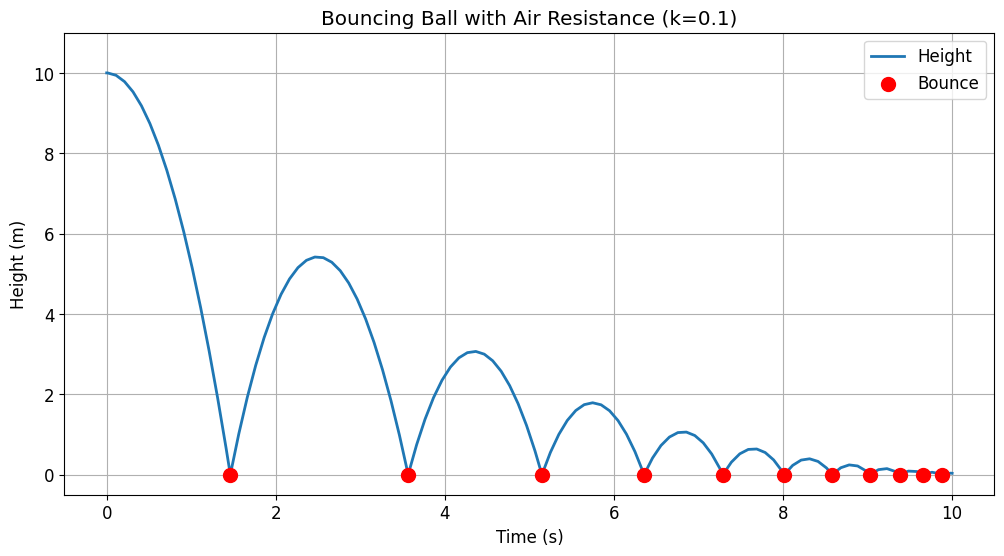

Number of bounces: 11
Bounce times: [1.46264619 3.566094   5.14820209 6.35621268 7.28867923 8.01428657
 8.58237453 9.02921449 9.38195066 9.66118118 9.88270813]


In [8]:
# Bouncing ball with gravity and air resistance
t, h, v, g, k = symbols('t, h, v, g, k')

# Event: ball hits ground (h = 0)
# When h crosses 0 going down, reverse velocity with 80% energy loss
ground_hit = SymbolicPreciseEvent(
    name="ground_hit",
    event=h,                    # Triggers when h = 0
    direction=-1,               # Only when falling (h going from + to -)
    mask=[0, -0.8*v],          # Set h=0 exactly, reverse velocity with 80% restitution
    event_tol=1e-12
)

# Create system: dh/dt = v, dv/dt = -g - k*v (air resistance)
bouncing_ball = OdeSystem(
    ode_sys=[v, -g - k*v],
    t=t,
    q=[h, v],
    args=[g, k],
    events=[ground_hit]
)

# Solve with limited max_step to ensure bounces are detected
solver = bouncing_ball.get(
    t0=0, q0=[10.0, 0.0],      # Start at height 10
    args=(9.81, 0.1),          # Gravity and air resistance coefficient
    method="RK45",
    max_step=0.1               # Limit step size to detect all bounces
)

result = solver.integrate(10.0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(result.t, result.q[:, 0], linewidth=2, label='Height')

# Mark events
t_events, q_events = result.event_data('ground_hit')
plt.scatter(t_events, q_events[:, 0], color='red', s=100, zorder=5, label='Bounce')

plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Bouncing Ball with Air Resistance (k=0.1)')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 11)
plt.show()

print(f"Number of bounces: {len(t_events)}")
print(f"Bounce times: {t_events}")

### 1.5.2 Periodic Events

Trigger at regular time intervals:

Compiling...
Done


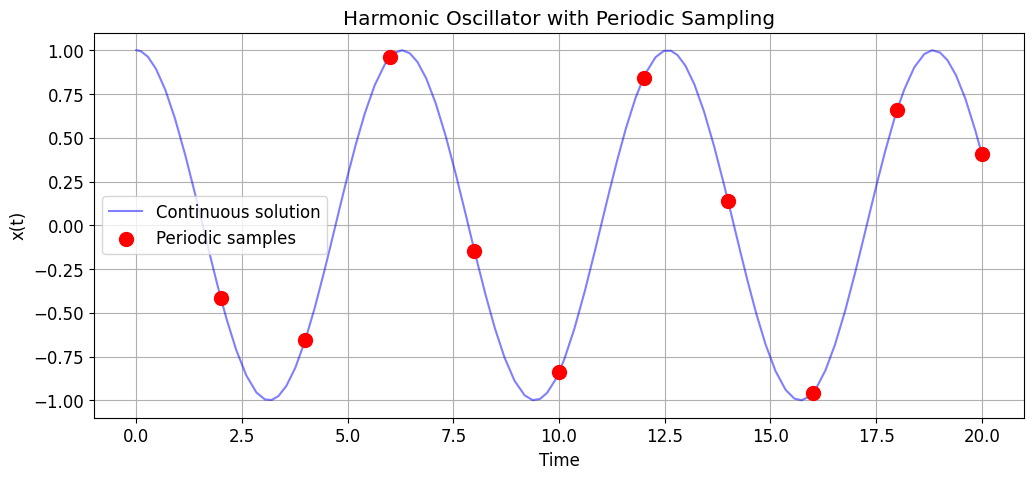

Samples collected: 10


In [9]:
# Simple harmonic oscillator with periodic sampling
t, x, v = symbols('t, x, v')

# Sample every 2 time units
periodic_sample = SymbolicPeriodicEvent(
    name="sample",
    period=2.0
)

system = OdeSystem(
    ode_sys=[v, -x],
    t=t,
    q=[x, v],
    events=[periodic_sample]
)

solver = system.get(t0=0, q0=[1.0, 0.0], method="RK45")
result = solver.integrate(20.0)

# Get sampled points
t_sample, q_sample = result.event_data('sample')

plt.figure(figsize=(12, 5))
plt.plot(result.t, result.q[:, 0], 'b-', alpha=0.5, label='Continuous solution')
plt.scatter(t_sample, q_sample[:, 0], color='red', s=100, zorder=5, label='Periodic samples')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Harmonic Oscillator with Periodic Sampling')
plt.legend()
plt.grid(True)
plt.show()

print(f"Samples collected: {len(t_sample)}")

### 1.5.3 Event Options and Termination

Control event behavior with `EventOpt`.

**Example: Stopping after a fixed number of bounces**

Same bouncing ball system as before, but we'll stop after exactly 5 bounces:

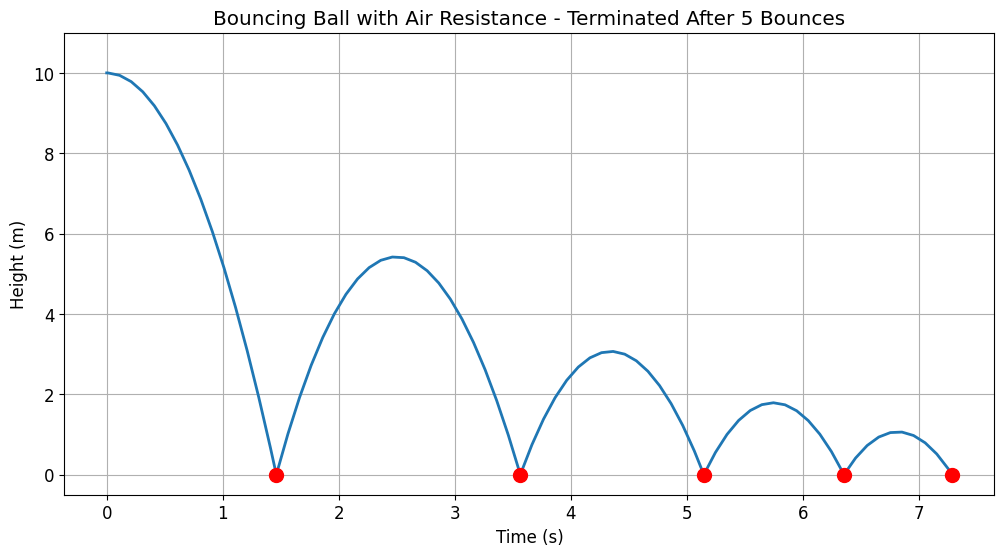

Integration stopped at t=7.289
Message: Max events reached


In [10]:
# Stop integration after 5 bounces - with air resistance
t, h, v, g, k = symbols('t, h, v, g, k')

ground_hit = SymbolicPreciseEvent(
    name="ground_hit",
    event=h,
    direction=-1,
    mask=[0, -0.8*v]
)

system = OdeSystem([v, -g - k*v], t, [h, v], args=[g, k], events=[ground_hit])
solver = system.get(
    t0=0, q0=[10.0, 0.0],
    args=(9.81, 0.1),      # Gravity and air resistance coefficient
    method="RK45",
    max_step=0.1  # Ensure events are detected
)

# Event option: stop after 5 bounces
event_opt = EventOpt(
    name="ground_hit",
    max_events=5,      # Only record 5 events
    terminate=True     # Stop integration after reaching max_events
)

result = solver.integrate(100.0, event_options=[event_opt])

plt.figure(figsize=(12, 6))
plt.plot(result.t, result.q[:, 0], linewidth=2)
t_events, q_events = result.event_data('ground_hit')
plt.scatter(t_events, q_events[:, 0], color='red', s=100, zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Bouncing Ball with Air Resistance - Terminated After 5 Bounces')
plt.ylim(-0.5, 11)
plt.grid(True)
plt.show()

print(f"Integration stopped at t={result.t[-1]:.3f}")
print(f"Message: {result.message}")

## 1.6. Advanced Integration

### 1.6.1 Multiple Integration Calls

LowLevelODE accumulates history across multiple integration calls:

Integrating in multiple steps:
Step 1: t=5.0, total points=32
Step 2: t=10.0, total points=57
Step 3: t=15.0, total points=82
Step 4: t=20.0, total points=107
Step 5: t=25.0, total points=132


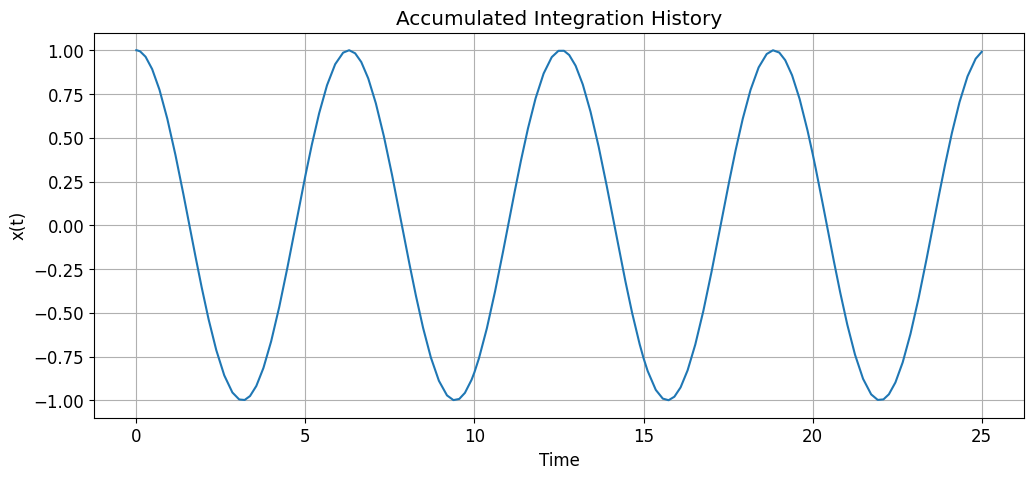

In [11]:
# Create a simple system
t, x, v = symbols('t, x, v')
system = OdeSystem([v, -x], t, [x, v])
solver = system.get(t0=0, q0=[1.0, 0.0], method="RK45")

# Integrate in steps
print("Integrating in multiple steps:")
for i in range(5):
    result = solver.integrate(5.0)
    print(f"Step {i+1}: t={solver.t[-1]:.1f}, total points={len(solver.t)}")

# Plot accumulated history
plt.figure(figsize=(12, 5))
plt.plot(solver.t, solver.q[:, 0])
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Accumulated Integration History')
plt.grid(True)
plt.show()

### 1.6.2 go_to() - Integrate to Specific Time

In [12]:
# Reset and use go_to
solver.reset()  # Back to initial conditions

# Integrate to specific times
times = [5, 10, 15, 20]
for t_target in times:
    result = solver.go_to(t_target)
    print(f"Reached t={result.t[-1]:.1f}, x={result.q[-1, 0]:.4f}")

Reached t=5.0, x=0.2837
Reached t=10.0, x=-0.8391
Reached t=15.0, x=-0.7597
Reached t=20.0, x=0.4081


### 1.6.3 rich_integrate() - Integration with Interpolation

Use `rich_integrate()` to get a callable solution object:

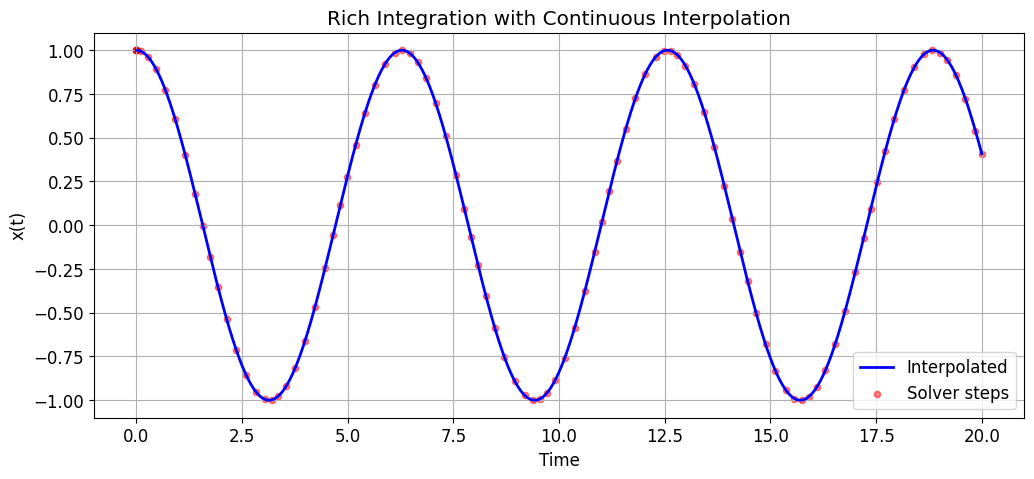

Solver steps: 104
Interpolated points: 1000


In [13]:
# Reset
solver.reset()

# Rich integration returns interpolable solution
solution = solver.rich_integrate(20.0)

# Evaluate at arbitrary times
t_interp = np.linspace(0, 20, 1000)
q_interp = solution(t_interp)

plt.figure(figsize=(12, 5))
plt.plot(t_interp, q_interp[:, 0], 'b-', linewidth=2, label='Interpolated')
plt.scatter(solution.t, solution.q[:, 0], color='red', s=20, alpha=0.5, label='Solver steps')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Rich Integration with Continuous Interpolation')
plt.legend()
plt.grid(True)
plt.show()

print(f"Solver steps: {len(solution.t)}")
print(f"Interpolated points: {len(t_interp)}")

### 1.6.4 Custom t_eval

Specify exact times to store:

In [14]:
solver.reset()

# Store solution only at specific times
t_eval = np.linspace(0, 20, 101)  # Exactly 101 points
result = solver.integrate(20.0, t_eval=t_eval)

print(f"Requested {len(t_eval)} points, got {len(result.t)} points")
print(f"Times match exactly: {np.allclose(result.t, t_eval)}")

Requested 101 points, got 101 points
Times match exactly: True


## 1.7. Variational Equations & Lyapunov Exponents

Variational equations track how perturbations grow, enabling computation of Lyapunov exponents.

### 1.7.1 Lorenz System - Classic Chaos Example

The Lorenz system is a classic example of chaotic dynamics:

$$\frac{dx}{dt} = \sigma(y - x)$$
$$\frac{dy}{dt} = x(\rho - z) - y$$
$$\frac{dz}{dt} = xy - \beta z$$

where:
- $\sigma = 10$ (Prandtl number)
- $\rho = 28$ (Rayleigh number)
- $\beta = 8/3$ (geometric factor)

With these parameters, the system exhibits chaotic behavior with a positive Lyapunov exponent ($\lambda \approx 0.906$).

Compiling...
Done
Computing Lyapunov exponents for Lorenz system...


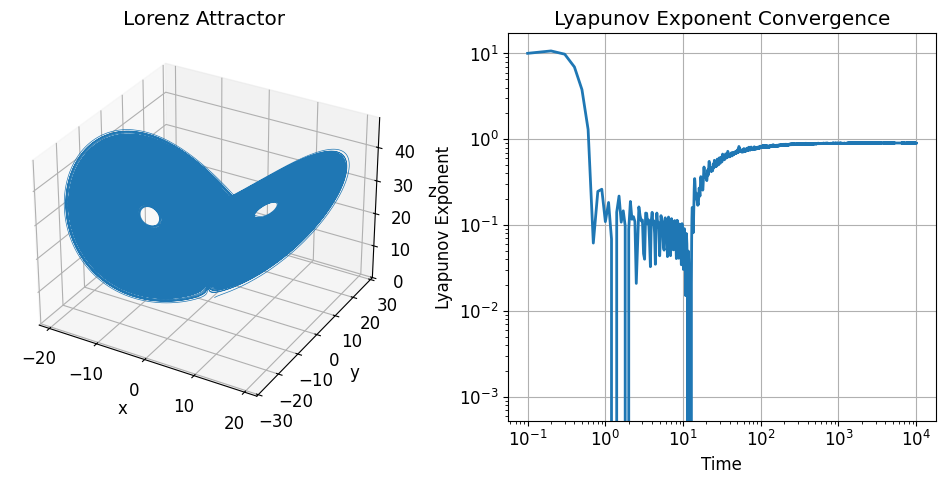


Final Lyapunov exponent: 0.905073
System is chaotic (λ > 0)
Expected for Lorenz: λ ≈ 0.906


In [15]:
# Lorenz system

t, x, y, z, sigma, rho, beta = symbols('t, x, y, z, sigma, rho, beta')

lorenz = OdeSystem(
    ode_sys=[
        sigma*(y - x),
        x*(rho - z) - y,
        x*y - beta*z
    ],
    t=t,
    q=[x, y, z],
    args=[sigma, rho, beta]
)

# Create variational solver
# q0 needs 2*Nsys elements: first Nsys for base system, last Nsys for variational direction
solver_var = lorenz.get_variational(
    t0=0,
    q0=[1.0, 1.0, 1.0,      # Initial conditions for base system (x, y, z)
        1.0, 0.0, 0.0],     # Variational direction (automatically normalized)
    period=0.1,              # Renormalization period
    args=(10.0, 28.0, 8/3),  # sigma, rho, beta
    method="RK45",
    rtol=1e-9, atol=1e-12
)

# Integrate
print("Computing Lyapunov exponents for Lorenz system...")
result = solver_var.integrate(10000.0)

# Plot Lorenz attractor
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(result.q[:, 0], result.q[:, 1], result.q[:, 2], linewidth=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Lorenz Attractor')

# Plot Lyapunov exponent convergence
ax2 = fig.add_subplot(132)
ax2.loglog(solver_var.t_lyap, solver_var.lyap, linewidth=2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Lyapunov Exponent')
ax2.set_title('Lyapunov Exponent Convergence')
ax2.grid(True)


plt.tight_layout()
plt.show()

lyap_final = solver_var.lyap[-1]
print(f"\nFinal Lyapunov exponent: {lyap_final:.6f}")
print(f"System is {'chaotic (λ > 0)' if lyap_final > 0 else 'stable (λ < 0)'}")
print(f"Expected for Lorenz: λ ≈ 0.906")

### 1.7.2 Comparing Chaotic vs Stable Systems

Compiling...
Done


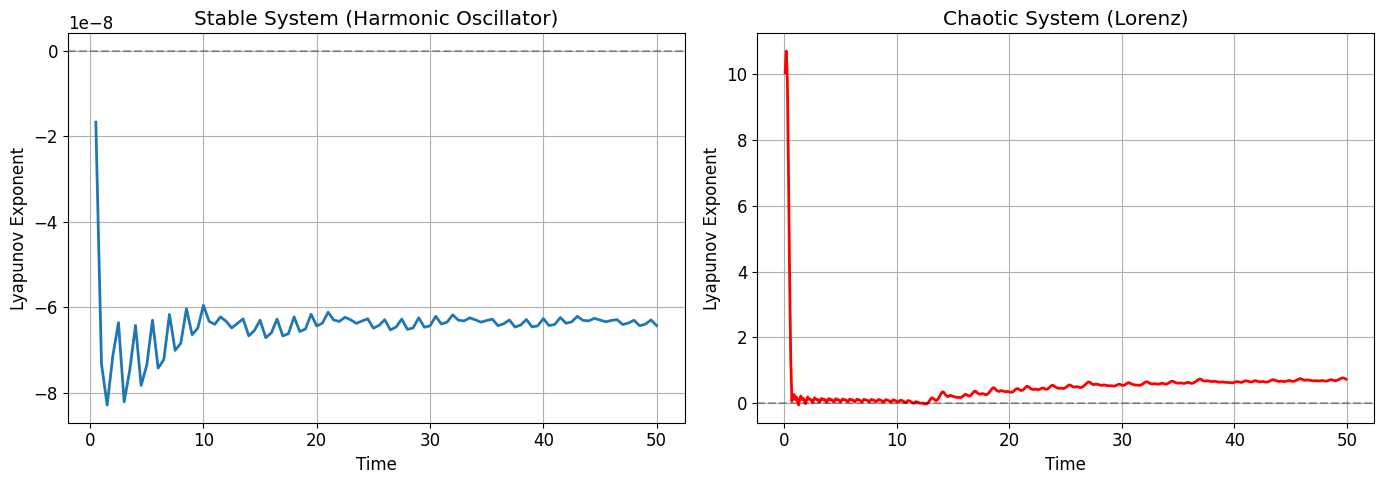

Stable system λ = -0.000000 (≈ 0)
Chaotic system λ = 0.732406 (> 0)


In [16]:
# Stable oscillator
t, x, v = symbols('t, x, v')
stable = OdeSystem([v, -x], t, [x, v])

# For 2D system, q0 needs 4 elements: [x0, v0, dx0, dv0]
solver_stable = stable.get_variational(
    t0=0,
    q0=[1.0, 0.0,     # Base system initial conditions
        1.0, 0.0],    # Variational direction
    period=0.5,
    method="RK45"
)
solver_stable.integrate(50.0)

# Chaotic Lorenz (from before)
solver_chaotic = lorenz.get_variational(
    t0=0,
    q0=[1.0, 1.0, 1.0,    # Base system
        1.0, 0.0, 0.0],   # Variational direction
    period=0.1,
    args=(10.0, 28.0, 8/3),
    method="RK45"
)
solver_chaotic.integrate(50.0)

# Compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(solver_stable.t_lyap, solver_stable.lyap, linewidth=2)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('Time')
ax1.set_ylabel('Lyapunov Exponent')
ax1.set_title('Stable System (Harmonic Oscillator)')
ax1.grid(True)

ax2.plot(solver_chaotic.t_lyap, solver_chaotic.lyap, linewidth=2, color='red')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Lyapunov Exponent')
ax2.set_title('Chaotic System (Lorenz)')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Stable system λ = {solver_stable.lyap[-1]:.6f} (≈ 0)")
print(f"Chaotic system λ = {solver_chaotic.lyap[-1]:.6f} (> 0)")

## 1.8. Hamiltonian Systems

ODEPACK provides built-in support for 2D Hamiltonian systems.

### 1.8.1 2D Harmonic Oscillator

A 2D isotropic harmonic oscillator with potential:

$$V(x, y) = \frac{1}{2}(x^2 + y^2)$$

The Hamiltonian equations of motion are:

$$\frac{dx}{dt} = \frac{\partial H}{\partial p_x} = p_x$$
$$\frac{dy}{dt} = \frac{\partial H}{\partial p_y} = p_y$$
$$\frac{dp_x}{dt} = -\frac{\partial H}{\partial x} = -x$$
$$\frac{dp_y}{dt} = -\frac{\partial H}{\partial y} = -y$$

where $H = \frac{1}{2}(p_x^2 + p_y^2) + V(x, y)$ is the total energy (conserved).

Compiling...
Done


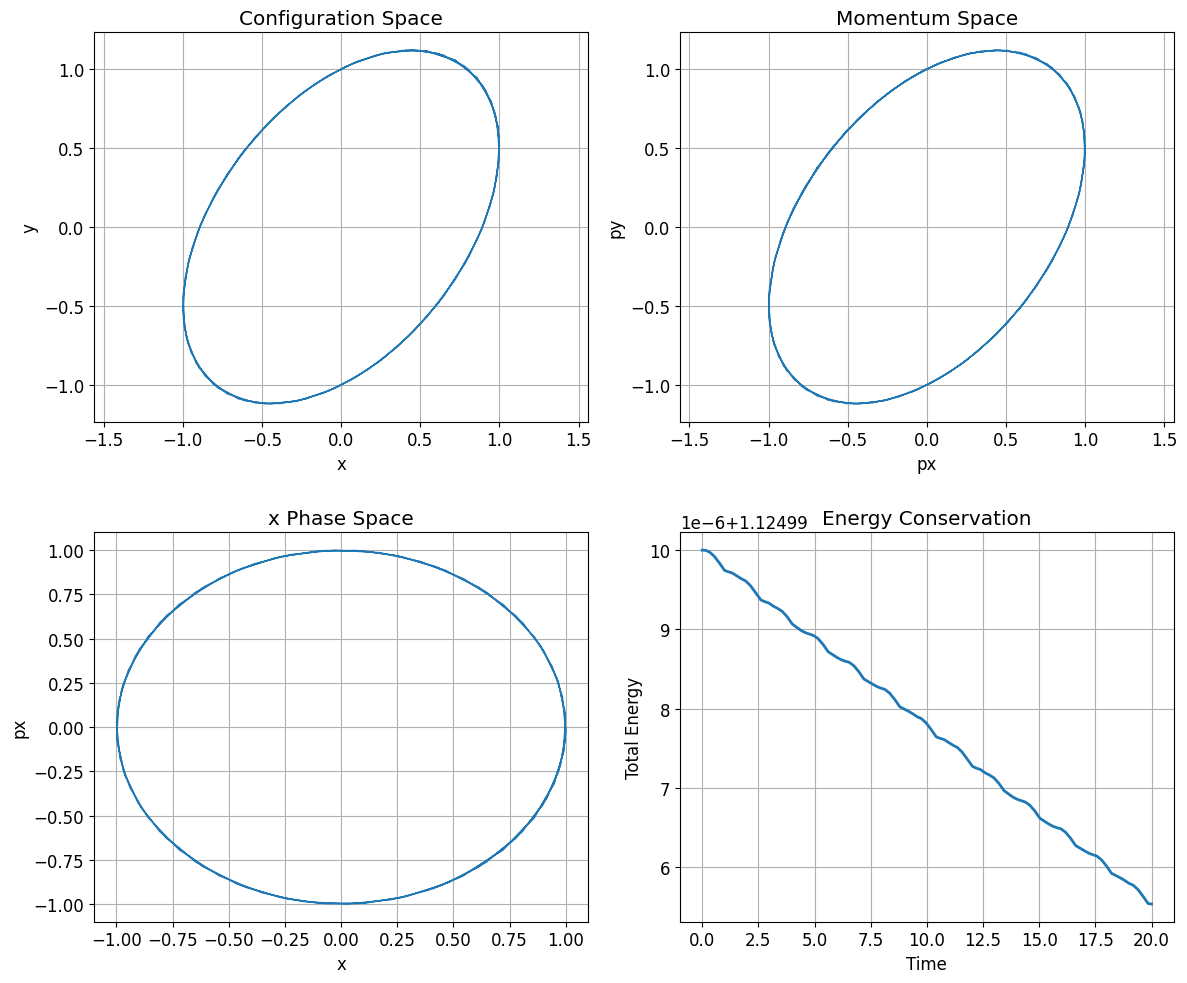

Relative energy error: 3.968e-06


In [17]:
# Define potential: V = (x^2 + y^2) / 2
t, x, y, px, py = symbols('t, x, y, px, py')
V = (x**2 + y**2) / 2

# Create Hamiltonian system
hamiltonian = HamiltonianSystem2D(
    V=V,
    t=t,
    x=x, y=y,
    px=px, py=py
)

# Solve
solver = hamiltonian.get(
    t0=0,
    q0=[1.0, 0.5, 0.0, 1.0],  # x, y, px, py
    method="RK45"
)

result = solver.integrate(20.0)

# Plot phase space
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Position space
axes[0, 0].plot(result.q[:, 0], result.q[:, 1], linewidth=1)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Configuration Space')
axes[0, 0].axis('equal')
axes[0, 0].grid(True)

# Momentum space
axes[0, 1].plot(result.q[:, 2], result.q[:, 3], linewidth=1)
axes[0, 1].set_xlabel('px')
axes[0, 1].set_ylabel('py')
axes[0, 1].set_title('Momentum Space')
axes[0, 1].axis('equal')
axes[0, 1].grid(True)

# x phase space
axes[1, 0].plot(result.q[:, 0], result.q[:, 2], linewidth=1)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('px')
axes[1, 0].set_title('x Phase Space')
axes[1, 0].grid(True)

# Energy conservation
H = (result.q[:, 2]**2 + result.q[:, 3]**2) / 2 + (result.q[:, 0]**2 + result.q[:, 1]**2) / 2
axes[1, 1].plot(result.t, H, linewidth=2)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Total Energy')
axes[1, 1].set_title('Energy Conservation')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

energy_error = (H.max() - H.min()) / H.mean()
print(f"Relative energy error: {energy_error:.3e}")

### 1.8.2 Double-Well Potential

A double-well potential with two stable equilibria:

$$V(x, y) = (x^2 - a)^2 + y^2$$

For $a = 1$, this creates two potential wells at $x = \pm 1$. Depending on the initial energy:
- **Low energy**: particle trapped in one well
- **Medium energy**: particle can transition between wells
- **High energy**: complex dynamics exploring both wells

Compiling...
Done


/tmp/ipykernel_4147/3484391031.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


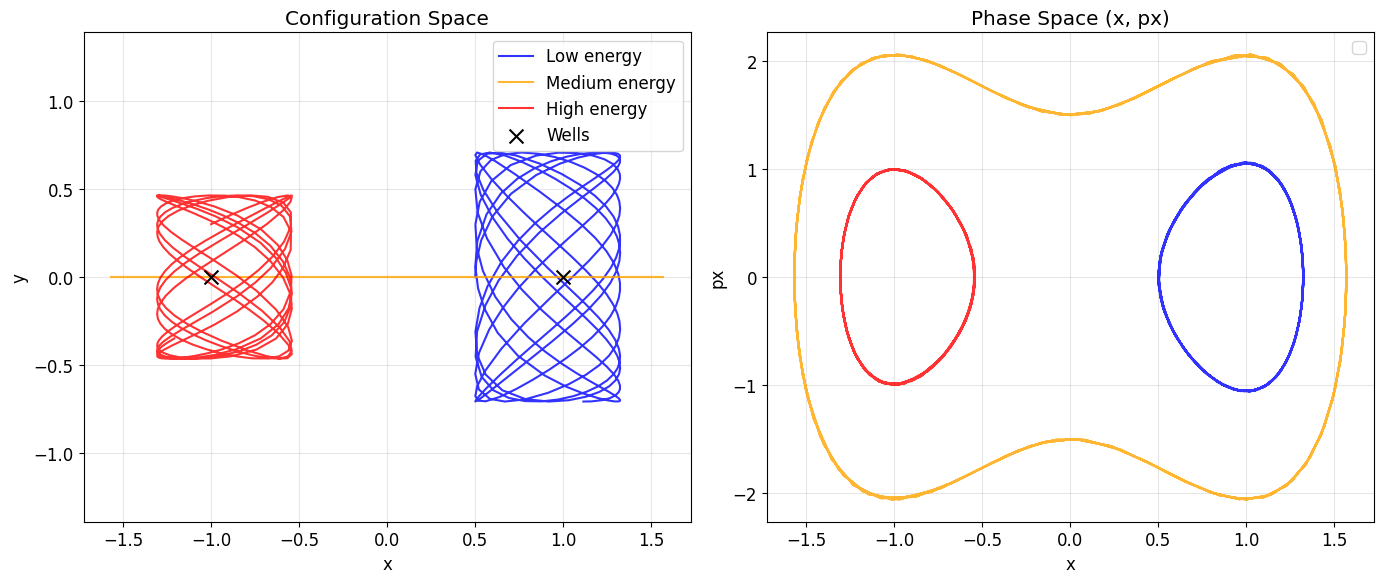


Double-well potential has minima at x = ±1
Low energy: trapped in one well
Medium energy: can transition between wells
High energy: explores both wells with complex dynamics


In [18]:
# Double-well: V = (x^2 - 1)^2 + y^2
t, x, y, px, py, a = symbols('t, x, y, px, py, a')
V = (x**2 - a)**2 + y**2

double_well = HamiltonianSystem2D(
    V=V, t=t, x=x, y=y, px=px, py=py,
    args=[a]
)

# Multiple trajectories exploring different regions of phase space
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Different initial conditions to explore the double-well structure
initial_conditions = [
    ([0.5, 0.0, 0.0, 1.0], 'blue', 'Low energy'),     # Oscillates in one well
    ([0.0, 0.0, 1.5, 0.0], 'orange', 'Medium energy'), # Transitions between wells
    ([-1.0, 0.3, 1.0, 0.5], 'red', 'High energy')      # Complex motion
]

for (q0, color, label) in initial_conditions:
    solver = double_well.get(
        t0=0, q0=q0,
        args=(1.0,),
        method="RK45"
    )
    result = solver.integrate(30.0)
    
    axes[0].plot(result.q[:, 0], result.q[:, 1], color=color, label=label, linewidth=1.5, alpha=0.8)
    axes[1].plot(result.q[:, 0], result.q[:, 2], color=color, linewidth=1.5, alpha=0.8)

# Mark the potential minima (wells at x = ±1)
axes[0].scatter([1, -1], [0, 0], color='black', s=100, marker='x', zorder=5, label='Wells')

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Configuration Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

axes[1].set_xlabel('x')
axes[1].set_ylabel('px')
axes[1].set_title('Phase Space (x, px)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDouble-well potential has minima at x = ±1")
print("Low energy: trapped in one well")
print("Medium energy: can transition between wells")
print("High energy: explores both wells with complex dynamics")

## 1.9. Parallel Integration

Use `integrate_all()` to solve multiple ODEs in parallel.

### 1.9.1 Parameter Sweep

The Van der Pol oscillator:

$$\frac{d^2x}{dt^2} = \mu(1-x^2)\frac{dx}{dt} - x$$

or as a first-order system:

$$\frac{dx}{dt} = v$$
$$\frac{dv}{dt} = \mu(1-x^2)v - x$$

The parameter $\mu$ controls the nonlinearity. We'll integrate for multiple values of $\mu$ in parallel to see how the limit cycle changes.

Compiling...
Done
Integrating in parallel...
Progress: 1e+02% : 5/5  Time elapsed : 0 h, 0 m, 0 s      Estimated duration: 0 h, 0 m, 0 sK
Parallel integration completed in: 0 h, 0 m, 0 s


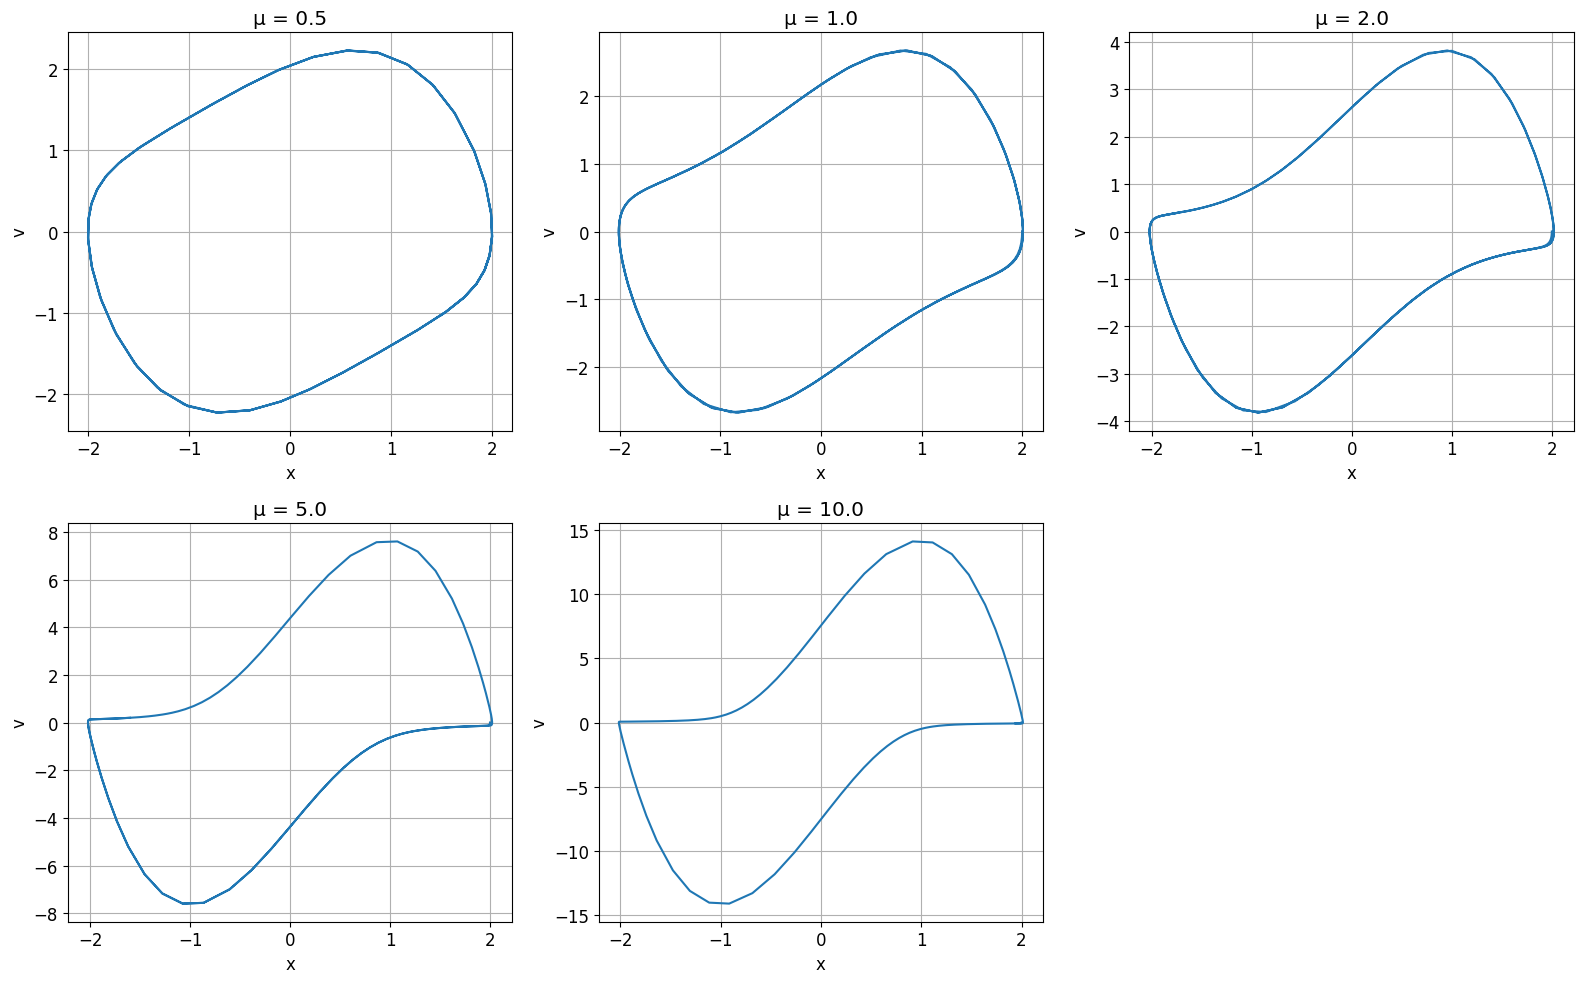


Integration times:
μ =   0.5: 0.000054 s, 130 steps
μ =   1.0: 0.000070 s, 180 steps
μ =   2.0: 0.000111 s, 249 steps
μ =   5.0: 0.000129 s, 316 steps
μ =  10.0: 0.000141 s, 360 steps


In [19]:
# Solve Van der Pol for different mu values
t, x, v, mu = symbols('t, x, v, mu')
system = OdeSystem([v, mu*(1 - x**2)*v - x], t, [x, v], args=[mu])

# Create array of solvers
mu_values = [0.5, 1.0, 2.0, 5.0, 10.0]
solvers = []

for mu_val in mu_values:
    solver = system.get(
        t0=0, q0=[2.0, 0.0],
        args=(mu_val,),
        method="RK45"
    )
    solvers.append(solver)

# Integrate all in parallel
print("Integrating in parallel...")
integrate_all(
    solvers,
    interval=20.0,
    threads=-1,  # Use all available CPU cores
    display_progress=True
)

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (solver, mu_val) in enumerate(zip(solvers, mu_values)):
    axes[i].plot(solver.q[:, 0], solver.q[:, 1], linewidth=1.5)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('v')
    axes[i].set_title(f'μ = {mu_val}')
    axes[i].grid(True)

axes[-1].axis('off')  # Hide last subplot
plt.tight_layout()
plt.show()

print("\nIntegration times:")
for solver, mu_val in zip(solvers, mu_values):
    print(f"μ = {mu_val:5.1f}: {solver.runtime:.6f} s, {len(solver.t)} steps")

### 1.9.2 Initial Condition Sensitivity

Chaotic systems exhibit sensitive dependence on initial conditions. We'll integrate the Lorenz system with many slightly perturbed initial conditions to visualize this phenomenon.

Lorenz system (same as before):

$$\frac{dx}{dt} = \sigma(y - x), \quad \frac{dy}{dt} = x(\rho - z) - y, \quad \frac{dz}{dt} = xy - \beta z$$

Compiling...
Done

Parallel integration completed in: 0 h, 0 m, 0 s


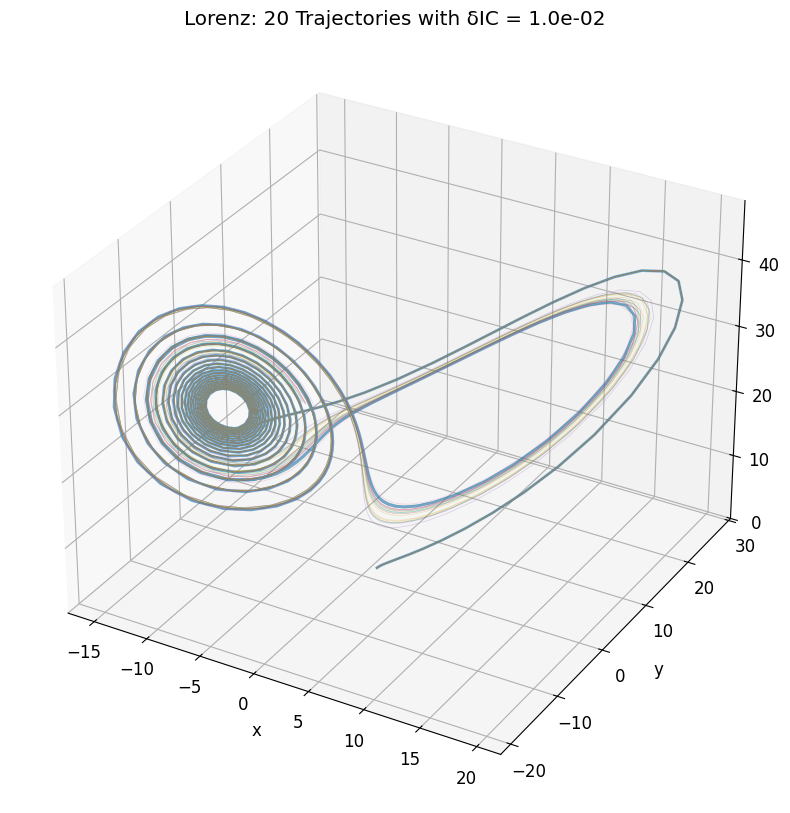

All 20 trajectories integrated in parallel


In [20]:
# Lorenz system with nearby initial conditions
t, x, y, z, sigma, rho, beta = symbols('t, x, y, z, sigma, rho, beta')
lorenz = OdeSystem(
    [sigma*(y - x), x*(rho - z) - y, x*y - beta*z],
    t, [x, y, z],
    args=[sigma, rho, beta]
)

# Create solvers with slightly perturbed initial conditions
n_traj = 20
perturbation = 1e-2
solvers = []

np.random.seed(42)
for _ in range(n_traj):
    q0 = [1.0, 1.0, 1.0] + perturbation * np.random.randn(3)
    solver = lorenz.get(
        t0=0, q0=q0,
        args=(10.0, 28.0, 8/3),
        method="RK45"
    )
    solvers.append(solver)

# Integrate all
integrate_all(solvers, interval=15.0, threads=-1)

# Plot in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, solver in enumerate(solvers):
    alpha = 0.6 if i == 0 else 0.3
    linewidth = 2 if i == 0 else 0.5
    ax.plot(solver.q[:, 0], solver.q[:, 1], solver.q[:, 2],
            linewidth=linewidth, alpha=alpha)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'Lorenz: {n_traj} Trajectories with δIC = {perturbation:.1e}')
plt.show()

print(f"All {n_traj} trajectories integrated in parallel")

## 10. Numerical Precision

ODEPACK supports multiple scalar types:

| Type | Description | Precision |
|------|-------------|----------|
| `'double'` | IEEE 754 double | 53 bits (~16 digits) |
| `'float'` | IEEE 754 single | 24 bits (~7 digits) |
| `'long double'` | Extended precision | 64-128 bits (platform-dependent) |
| `'mpreal'` | Arbitrary precision (MPFR) | User-specified |

### 10.1 Comparing Precision Types

In [21]:
# Simple oscillator

from odepack import *
import numpy as np
import matplotlib.pyplot as plt

t, x, v = symbols('t, x, v')
system = OdeSystem([v, -x], t, [x, v])

scalar_types = ['double', 'float', 'long double']
results = {}

print("Comparing scalar types:")
print(f"{'Type':<15} {'Runtime (s)':<15} {'Final Error':<15} {'Steps'}")
print("-" * 60)

for stype in scalar_types:
    solver = system.get(
        t0=0, q0=[1.0, 0.0],
        method="RK45",
        scalar_type=stype,
        rtol=1e-12, atol=1e-15
    ) #such small toletances do not work with 'float' due to precision limits
    result = solver.integrate(100.0)
    results[stype] = result
    
    # Analytical: x(t) = cos(t)
    x_true = np.cos(result.t[-1])
    error = abs(result.q[-1, 0] - x_true)
    
    print(f"{stype:<15} {result.runtime:<15.6f} {error:<15.3e} {len(result.t)}")

Comparing scalar types:
Type            Runtime (s)     Final Error     Steps
------------------------------------------------------------
double          0.002132        9.803e-12       8107
Compiling...
Done
float           0.000011        0.000e+00       1
Compiling...
Done
long double     0.007460        9.859e-12       8107


### 10.2 Arbitrary Precision with mpreal

In [22]:
# Set mpreal precision to 256 bits (~77 decimal digits)
set_mpreal_prec(100)
print(f"MPREAL precision set to {mpreal_prec()} bits")

# Solve with arbitrary precision
solver_mpreal = system.get(
    t0=0, q0=[1.0, 0.0],
    method="RK45",
    scalar_type='mpreal',
    rtol=1e-30, atol=1e-35
)
# notice how much smaller tolerances can be set with mpreal
# try to do the same with 'double' would lead to errors due to precision limits


result_mpreal = solver_mpreal.integrate(1)
print(result_mpreal.message)

print(f"\nArbitrary precision integration:")
print(f"Runtime: {result_mpreal.runtime:.6f} seconds")
print(f"Steps: {len(result_mpreal.t)}")
print(f"\nNote: mpreal is much slower but can achieve arbitrary precision")

MPREAL precision set to 100 bits
Compiling...
Done
t-goal

Arbitrary precision integration:
Runtime: 3.636739 seconds
Steps: 314522

Note: mpreal is much slower but can achieve arbitrary precision


## 11. Performance Tips

### 11.1 Always Use Symbolic Compilation

In [23]:
import time
from scipy.integrate import solve_ivp

# Define Van der Pol system
t, x, v, mu = symbols('t, x, v, mu')

# Symbolic (compiled)
system_sym = OdeSystem([v, mu*(1-x**2)*v - x], t, [x, v], args=[mu])
solver_sym = system_sym.get(t0=0, q0=[2.0, 0.0], args=(5.0,), method="BDF", rtol=1e-6, atol=1e-9)

# Python function
def vdp(t, q, mu):
    return np.array([q[1], mu*(1-q[0]**2)*q[1] - q[0]])

def vdp_jac(t, q, mu):
    x, y = q
    return np.array([[0, 1], [-2*mu*x*y - 1, mu*(1-x**2)]])

solver_py = LowLevelODE(
    vdp, t0=0, q0=[2.0, 0.0],
    args=(5.0,), method="BDF", rtol=1e-6, atol=1e-9
)

# Compare all three: SciPy, ODEPACK Python, ODEPACK Compiled
# All use the same tolerances for fair comparison
print("Performance comparison (Van der Pol, t=0 to t=50):")
print("Using rtol=1e-6, atol=1e-9 for all methods\n")
print(f"{'Method':<25} {'Time (s)':<12} {'Steps':<10} {'Speedup'}")
print("-" * 65)

# SciPy
t0 = time.time()
sol_scipy = solve_ivp(vdp, (0, 50), [2.0, 0.0], method='BDF', args=(5.0,), rtol=1e-6, atol=1e-9)
t_scipy = time.time() - t0
print(f"{'SciPy solve_ivp':<25} {t_scipy:<12.6f} {len(sol_scipy.t):<10} 1.0x")

# ODEPACK with Python function
t0 = time.time()
solver_py.integrate(50.0)
t_py = time.time() - t0
print(f"{'ODEPACK (Python func)':<25} {t_py:<12.6f} {len(solver_py.t):<10} {t_scipy/t_py:.1f}x")

# ODEPACK with compiled symbolic
t0 = time.time()
solver_sym.integrate(50.0)
t_sym = time.time() - t0
print(f"{'ODEPACK (Compiled)':<25} {t_sym:<12.6f} {len(solver_sym.t):<10} {t_scipy/t_sym:.1f}x")

print(f"\nConclusion: ODEPACK compiled is {t_scipy/t_sym:.0f}x faster than SciPy!")
print("Note: All methods use identical tolerances for fair comparison")

Performance comparison (Van der Pol, t=0 to t=50):
Using rtol=1e-6, atol=1e-9 for all methods

Method                    Time (s)     Steps      Speedup
-----------------------------------------------------------------
SciPy solve_ivp           0.212394     1879       1.0x
ODEPACK (Python func)     0.008662     1874       24.5x
ODEPACK (Compiled)        0.000640     1874       331.9x

Conclusion: ODEPACK compiled is 332x faster than SciPy!
Note: All methods use identical tolerances for fair comparison


### 11.2 Choose Appropriate Method

In [24]:
print("Method Selection Guide:")
print()
print("Non-stiff problems:")
print("  • RK23:   Fast, lower accuracy")
print("  • RK45:   Balanced (recommended default)")
print("  • DOP853: High accuracy, slower")
print()
print("Stiff problems:")
print("  • BDF:    Required for stiff systems")
print("           (needs Jacobian for best performance)")
print()
print("Tip: If explicit method takes tiny steps, try BDF!")

Method Selection Guide:

Non-stiff problems:
  • RK23:   Fast, lower accuracy
  • RK45:   Balanced (recommended default)
  • DOP853: High accuracy, slower

Stiff problems:
  • BDF:    Required for stiff systems
           (needs Jacobian for best performance)

Tip: If explicit method takes tiny steps, try BDF!


### 11.3 Reuse Compiled Systems

In [25]:
# Create system once
t, x, v, omega = symbols('t, x, v, omega')
system = OdeSystem([v, -omega**2 * x], t, [x, v], args=[omega])

# Compilation happens on first .get() call
print("First call (compiles):")
t0 = time.time()
solver1 = system.get(t0=0, q0=[1.0, 0.0], args=(1.0,), method="RK45")
print(f"  Time: {time.time() - t0:.6f} s")

# Subsequent calls reuse compiled code
print("\nSecond call (reuses compiled code):")
t0 = time.time()
solver2 = system.get(t0=0, q0=[2.0, 0.0], args=(2.0,), method="RK45")
print(f"  Time: {time.time() - t0:.6f} s")

print("\nTip: Reuse OdeSystem objects to avoid recompilation!")

First call (compiles):
Compiling...
Done
  Time: 4.209332 s

Second call (reuses compiled code):
  Time: 0.000111 s

Tip: Reuse OdeSystem objects to avoid recompilation!


### 11.4 Module Persistence

In [1]:
# Save compiled module to disk
import os
import glob
from odepack import *
import numpy as np
import matplotlib.pyplot as plt

t, x, v = symbols('t, x, v')

# Create directory with absolute path
module_dir = os.path.abspath('./compiled_modules')
os.makedirs(module_dir, exist_ok=True)

system_persistent = OdeSystem(
    [v, -x], t, [x, v],
    module_name='my_oscillator',  # Save with this name
    directory=module_dir           # Use absolute path
)

solver = system_persistent.get(t0=0, q0=[1.0, 0.0], method="RK45")

# Check for saved module (includes Python version in filename)
module_pattern = os.path.join(module_dir, 'my_oscillator_double*.so')
saved_files = glob.glob(module_pattern)

# print(f"Module directory: {module_dir}")
if saved_files:
    print(f"\n✓ Module successfully saved to disk!")
    for f in saved_files:
        print(f"  {os.path.basename(f)}")
    print("\nNext run will load from disk instead of recompiling!")
else:
    print(f"\n✗ No module files found")
    print(f"Searched for: {module_pattern}")
    print("Tip: Both module_name and directory must be provided to save to disk")

Compiling...
Done

✓ Module successfully saved to disk!
  my_oscillator_double.cpython-312-x86_64-linux-gnu.so

Next run will load from disk instead of recompiling!


## Summary

This tutorial covered:

1. **Basic ODE systems** - Defining and solving ODEs with symbolic expressions
2. **Symbolic vs Python** - Performance benefits of compilation (50-200x speedup)
3. **Integration methods** - RK23, RK45, DOP853, and BDF for stiff problems
4. **Event detection** - Precise and periodic events with state modification
5. **Advanced integration** - Multiple calls, interpolation, and custom output times
6. **Variational equations** - Lyapunov exponents for chaos detection
7. **Hamiltonian systems** - Built-in support for conservative systems
8. **Parallel integration** - Solve multiple ODEs simultaneously
9. **Numerical precision** - Float, double, long double, and arbitrary precision
10. **Performance tips** - Best practices for maximum speed

### Key Takeaways

- **Use symbolic definitions** for 50-200x speedup
- **Choose the right method**: RK45 for general use, BDF for stiff problems
- **Events are powerful**: Precisely detect conditions and modify state
- **Variational equations**: Built-in chaos detection with Lyapunov exponents
- **Parallel integration**: Use `integrate_all()` for parameter sweeps

Happy integrating!

# Chapter 2: Low-Level API

The low-level API provides direct access to `OdeSolver` classes (RK23, RK45, DOP853, BDF) for fine-grained control over integration. Use this when you need:

- Step-by-step manual control
- Custom termination conditions
- Real-time monitoring and visualization
- Debugging and diagnostics

The OdeSolver classes do not store any integration history, but only update their current state at each step, thus preserving memory.

**Note:** Use this chapter only when you need explicit control over each integration step.

## 2.1 Introduction to OdeSolver

The `OdeSolver` class provides direct step-by-step control over integration. 
This is useful for:

- Custom integration loops
- Real-time visualization during integration
- Debugging and diagnostics
- Fine-grained control over when to stop

Available solver classes:
- `RK23`, `RK45`, `DOP853`: Explicit Runge-Kutta methods
- `BDF`: Implicit method for stiff problems

## 2.2 Basic OdeSolver Usage

OdeSolver objects allow manual control over each integration step:

In [27]:
from odepack import RK45
import numpy as np

# Define ODE: simple harmonic oscillator
def f(t, q):
    return np.array([q[1], -q[0]])

# Create solver
solver = RK45(
    f=f,
    t0=0.0,
    q0=np.array([1.0, 0.0]),
    rtol=1e-6,
    atol=1e-9
)

# Manual stepping
print("Manual integration with OdeSolver:")
print(f"{'Step':<6} {'Time':<12} {'x':<12} {'Step Size':<12}")
print("-" * 48)

for i in range(10):
    print(f"{i:<6} {solver.t:<12.6f} {solver.q[0]:<12.6f} {solver.stepsize:<12.6f}")
    if not solver.advance():
        print("Solver stopped!")
        break

print(f"\nFinal state: t={solver.t:.6f}, x={solver.q[0]:.6f}, v={solver.q[1]:.6f}")

Manual integration with OdeSolver:
Step   Time         x            Step Size   
------------------------------------------------
0      0.000000     1.000000     0.000999    
1      0.000999     1.000000     0.009990    
2      0.010989     0.999940     0.099900    
3      0.110889     0.993858     0.163087    
4      0.273976     0.962703     0.194812    
5      0.468788     0.892116     0.216377    
6      0.685166     0.774314     0.232381    
7      0.917546     0.607771     0.241036    
8      1.158582     0.400639     0.235857    
9      1.394440     0.175444     0.215259    

Final state: t=1.574314, x=-0.003518, v=-0.999994


## 2.3 Custom Termination Conditions

Use `advance()` in a loop with custom stopping criteria:

Integrating until first zero-crossing...
Zero crossing detected at t = 1.574314


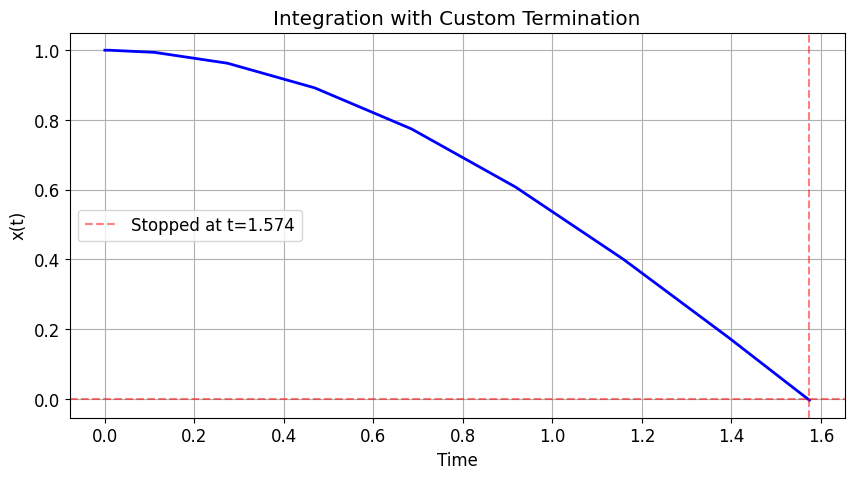

In [28]:
# Create new solver
solver = RK45(f, 0.0, np.array([1.0, 0.0]), rtol=1e-6, atol=1e-9)

# Store trajectory
t_vals = [solver.t]
x_vals = [solver.q[0]]

# Integrate until x crosses zero for the first time
print("Integrating until first zero-crossing...")
previous_x = solver.q[0]

while solver.t < 10.0:
    solver.advance()
    t_vals.append(solver.t)
    x_vals.append(solver.q[0])
    
    # Check for sign change (zero crossing)
    if previous_x > 0 and solver.q[0] < 0:
        print(f"Zero crossing detected at t = {solver.t:.6f}")
        break
    previous_x = solver.q[0]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(t_vals, x_vals, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=solver.t, color='r', linestyle='--', alpha=0.5, label=f'Stopped at t={solver.t:.3f}')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Integration with Custom Termination')
plt.legend()
plt.grid(True)
plt.show()

## 2.4 Real-Time Monitoring and Diagnostics

Access solver state during integration for monitoring.

**Example: Van der Pol oscillator (moderately stiff)**

With $\mu = 10$, the Van der Pol system becomes moderately stiff:

$$\frac{dx}{dt} = v$$
$$\frac{dv}{dt} = \mu(1-x^2)v - x$$

In [29]:
# Van der Pol oscillator (can be stiff)
def vdp(t, q, mu):
    return np.array([q[1], mu*(1 - q[0]**2)*q[1] - q[0]])

def vdp_jac(t, q, mu):
    x, y = q
    return np.array([[0, 1], [-2*mu*x*y - 1, mu*(1-x**2)]])

from odepack import BDF

solver = BDF(
    f=vdp,
    jac=vdp_jac,
    t0=0.0,
    q0=np.array([2.0, 0.0]),
    args=(10.0,),  # mu = 10 (moderately stiff)
    rtol=1e-6,
    atol=1e-9
)

# Monitor integration
print("Monitoring integration progress:")
print(f"{'Time':<12} {'x':<12} {'Step Size':<12} {'Dead?':<8}")
print("-" * 48)

step_count = 0
while solver.t < 20.0 and not solver.is_dead:
    solver.advance()
    step_count += 1
    
    # Print every 100 steps
    if step_count % 100 == 0:
        print(f"{solver.t:<12.6f} {solver.q[0]:<12.6f} {solver.stepsize:<12.6f} {solver.is_dead!s:<8}")

print(f"\nTotal steps: {step_count}")
print(f"Final time: {solver.t:.6f}")
print(f"Diverged: {solver.diverges}")

Monitoring integration progress:
Time         x            Step Size    Dead?   
------------------------------------------------
2.444225     1.827050     0.282013     False   
8.942630     0.357697     0.001173     False   
9.239219     -1.993539    0.003082     False   
10.558244    -1.932509    0.199529     False   
18.445658    -0.485832    0.009361     False   
18.763677    1.978620     0.003810     False   
19.370051    1.982681     0.031066     False   

Total steps: 711
Final time: 20.005130
Diverged: False


## 2.5 Solver State Inspection

OdeSolver provides properties to inspect its current state:

In [30]:
# Create a simple solver
def f(t, q):
    return np.array([q[1], -q[0]])

solver = RK45(f, 0.0, np.array([1.0, 0.0]), rtol=1e-6, atol=1e-9)

# Advance a few steps
for _ in range(5):
    solver.advance()

# Inspect state
print("Solver State Properties:")
print(f"Current time (t):        {solver.t}")
print(f"Current state (q):       {solver.q}")
print(f"Current step size:       {solver.stepsize}")
print(f"System dimension (Nsys): {solver.Nsys}")
print(f"Scalar type:             {solver.scalar_type}")
print(f"Is dead:                 {solver.is_dead}")
print(f"Diverges:                {solver.diverges}")

# Show detailed state
print("\nDetailed state information:")
solver.show_state(digits=6)

Solver State Properties:
Current time (t):        0.4687883243807181
Current state (q):       [ 0.89211636 -0.45180566]
Current step size:       0.21637718913151308
System dimension (Nsys): 2
Scalar type:             double
Is dead:                 False
Diverges:                False

Detailed state information:

OdeSolver current state:
---------------------------
	t          : 0.468788
	q          : 8.921164e-01 -4.518057e-01
	h          : 0.216377
	Diverges   : false
	Running    : true
	Updates    : 5
	Dead       : false
	State      : Running
	Events     : 



## 2.6 Copying and Resetting Solvers

Solvers can be copied to explore different paths or reset to initial conditions:

In [ ]:
# Create solver and integrate partway
solver1 = RK45(f, 0.0, np.array([1.0, 0.0]), rtol=1e-6, atol=1e-9)

# Advance to t=5
while solver1.t < 5.0:
    solver1.advance()

print(f"Solver 1 at t={solver1.t:.3f}, x={solver1.q[0]:.6f}")

# Copy solver to explore alternative path
solver2 = solver1.copy()

# Continue both solvers differently
while solver1.t < 10.0:
    solver1.advance()

while solver2.t < 15.0:
    solver2.advance()

print(f"Solver 1 at t={solver1.t:.3f}, x={solver1.q[0]:.6f}")
print(f"Solver 2 at t={solver2.t:.3f}, x={solver2.q[0]:.6f}")

# Reset solver1 to initial conditions
solver1.reset()
print(f"\nAfter reset:")
print(f"Solver 1 at t={solver1.t:.3f}, x={solver1.q[0]:.6f}")

Solver 1 at t=5.196, x=0.464753
Solver 1 at t=10.171, x=-0.734290
Solver 2 at t=15.142, x=-0.844025

After reset:
Solver 1 at t=0.000, x=1.000000


## 2.7 Event Detection with OdeSolver

OdeSolver can work with events using manual `advance()` calls.

**Example: Bouncing ball with air resistance**

Same physics as before:

$$\frac{dh}{dt} = v, \quad \frac{dv}{dt} = -g - kv$$

But now we detect bounces manually by checking when $h \approx 0$ with upward velocity after the mask is applied.

Detecting bounces with manual advance():
Bounce 1 detected at t=1.462646
Bounce 2 detected at t=3.566094
Bounce 3 detected at t=5.148202
Bounce 4 detected at t=6.356213
Bounce 5 detected at t=7.288679


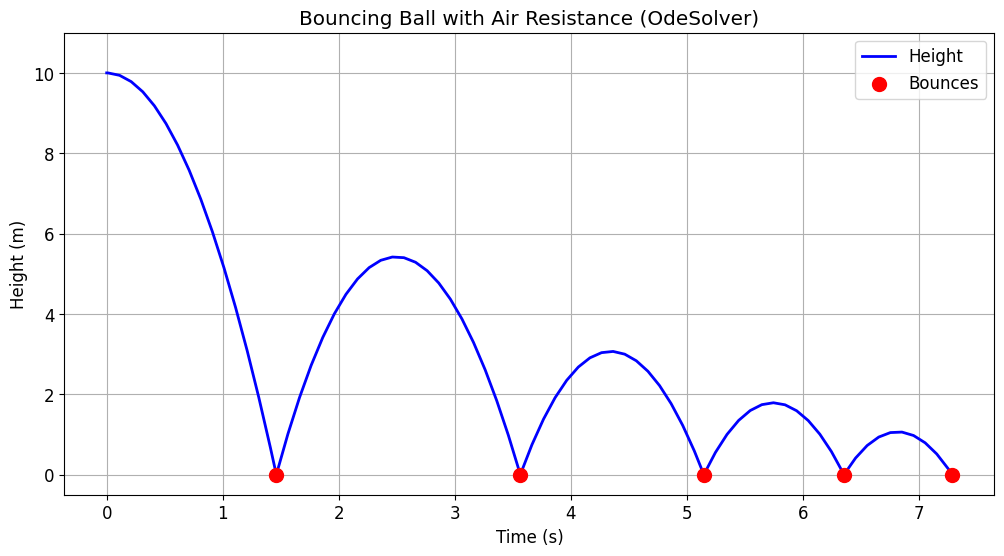

In [ ]:
from odepack import PreciseEvent

# Define bouncing ball with air resistance
def ball(t, q, g, k):
    return np.array([q[1], -g - k*q[1]])  # dh/dt = v, dv/dt = -g - k*v

# Event: ball hits ground
def ground_event(t, q, g, k):
    return q[0]  # h = 0

def bounce_mask(t, q, g, k):
    return np.array([0.0, -0.8*q[1]])  # h=0, reverse velocity with damping

event = PreciseEvent(
    name="ground",
    when=ground_event,
    direction=-1,
    mask=bounce_mask,
    event_tol=1e-12
)

# Create solver with event and air resistance
solver = RK45(
    f=ball,
    t0=0.0,
    q0=np.array([10.0, 0.0]),  # Start at height 10
    args=(9.81, 0.1),          # Gravity and air resistance
    events=[event],
    rtol=1e-6,
    atol=1e-9,
    max_step=0.1  # Limit step size to detect events
)

# Integrate and collect trajectory
t_traj, h_traj = [solver.t], [solver.q[0]]
t_bounces, h_bounces = [], []

print("Detecting bounces with manual advance():")
bounce_count = 0

while solver.t < 10.0 and bounce_count < 5:
    # Check if we just had an event before advancing
    had_event = False
    
    # Advance one step
    if not solver.advance():
        print("Solver stopped")
        break
    
    # Record trajectory point
    t_traj.append(solver.t)
    h_traj.append(solver.q[0])
    
    # Check if an event occurred (height near zero and going up after bounce)
    if abs(solver.q[0]) < 0.01 and solver.q[1] > 0:
        # Just bounced!
        bounce_count += 1
        t_bounces.append(solver.t)
        h_bounces.append(solver.q[0])
        print(f"Bounce {bounce_count} detected at t={solver.t:.6f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_traj, h_traj, 'b-', linewidth=2, label='Height')
plt.scatter(t_bounces, h_bounces, color='red', s=100, zorder=5, label='Bounces')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Bouncing Ball with Air Resistance (OdeSolver)')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 11)
plt.show()

## 2.8 OdeSolver Reference

Key OdeSolver methods:

| Method | Description |
|--------|-------------|
| `advance()` | Take one adaptive time step |
| `advance_to_event()` | Advance until next event |
| `reset()` | Reset to initial conditions |
| `copy()` | Create independent copy |
| `show_state()` | Print detailed state info |

Key properties:

| Property | Description |
|----------|-------------|
| `t` | Current time |
| `q` | Current state vector |
| `stepsize` | Current adaptive step size |
| `Nsys` | System dimension |
| `is_dead` | Cannot advance further |
| `diverges` | Solution has diverged |
| `scalar_type` | Numerical precision type |

**When to use OdeSolver directly:**
- Need fine-grained control over integration
- Custom termination conditions
- Real-time monitoring and visualization
- Debugging integration issues

**When to use LowLevelODE:**
- Standard integration tasks
- Need accumulated history
- Multiple integration calls
- Simpler API